In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model import HulaHoopLSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import create_sequences
import optuna
import matplotlib.lines as mlines

/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/jonaheaton/Documents/hulahoop_data/all_ellipse_data_final.csv')

## How much data is in the training, validation and test?

In [4]:
df.columns

Index(['frame', 'top ellipse X', 'top ellipse Y', 'top ellipse Major Axis',
       'top ellipse Minor Axis', 'top ellipse Angle', 'bottom ellipse X',
       'bottom ellipse Y', 'bottom ellipse Major Axis',
       'bottom ellipse Minor Axis', 'bottom ellipse Angle', 'video_id',
       'file_name', 'data_type'],
      dtype='object')

In [18]:
print('number of video files:', len(df['video_id'].unique()))
print('total number of frames:', len(df))
print(df['data_type'].value_counts())

print('------')
isnan_frames = df['top ellipse X'].isna().sum()
print('number of frames with NaN values:', isnan_frames)
print('percentage of frames with NaN values:', isnan_frames/len(df))
print('total number of real frames:', len(df) - isnan_frames)
data_no_nan = df.dropna(subset=['top ellipse X']).copy()
print(data_no_nan['data_type'].value_counts())

number of video files: 19
total number of frames: 40206
data_type
training      25308
validation     8321
test           6577
Name: count, dtype: int64
------
number of frames with NaN values: 1970
percentage of frames with NaN values: 0.04899766204049147
total number of real frames: 38236
data_type
training      24821
validation     7685
test           5730
Name: count, dtype: int64


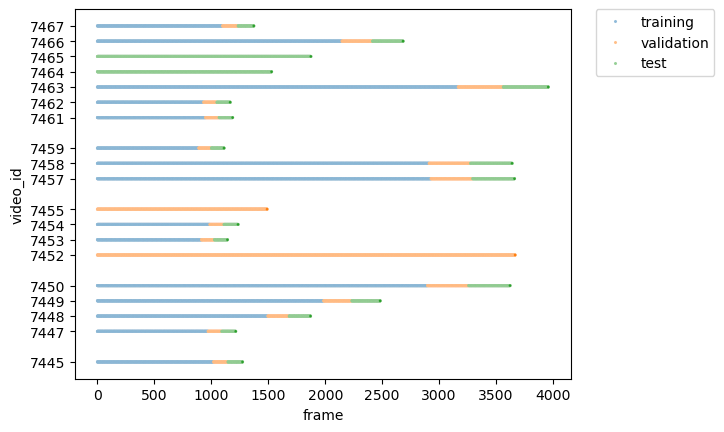

In [12]:
sns.scatterplot(data=df,y='video_id',x='frame',hue='data_type',alpha=0.5,s=5)
# place the legend outside the plot
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# add labels to each ytick
_ = plt.yticks(df['video_id'].unique(),df['video_id'].unique())

## Visualize the data


In [15]:
# PCA, UMAP
! pip install umap-learn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.2 MB/s eta 0:00:00a 0:00:01


/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
ellipse_cols = [col for col in data_no_nan.columns if 'ellipse' in col]

In [20]:
df_vals  =data_no_nan[ellipse_cols].values

n_components = 10
pca  = PCA(n_components=n_components)
principalComponents = pca.fit_transform(df_vals)
print('explained variance ratio: ', pca.explained_variance_ratio_)
pca_cols = ['PCA' + str(i) for i in range(1,n_components+1)]

explained variance ratio:  [0.40361623 0.32448357 0.22113937 0.02634916 0.01108575 0.00854541
 0.00281823 0.00093284 0.00055112 0.00047832]


In [44]:
print(df_vals.shape)

(38236, 10)


#### Note to self
I forgot to standard-scale this data before computing the pricipal components. I should do that before I do the PCA., not sure if i fully trust the plots below

In [24]:
viz_df = pd.DataFrame(data = principalComponents, columns = pca_cols)
viz_df['frame'] = df['frame']
viz_df['video_id'] = df['video_id']
viz_df['file_name'] = df['file_name']
viz_df['data_type'] = df['data_type']

Text(0, 0.5, 'Explained Variance Ratio')

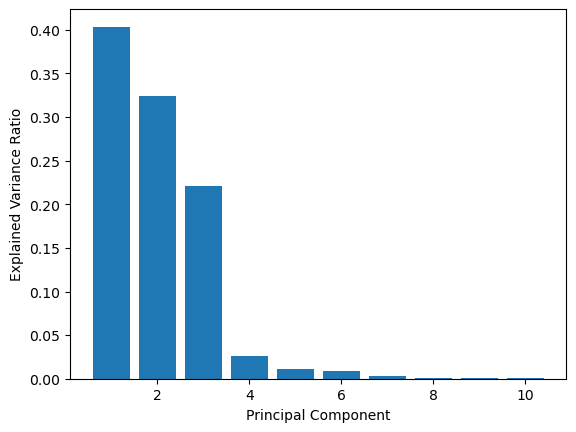

In [21]:
# plot explained variance ratio for each component 
plt.bar(range(1,n_components+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

In [22]:
mapper = umap.UMAP().fit(df_vals)
umap_df = mapper.transform(df_vals)
# umap_cols = ['UMAP1','UMAP2']

In [25]:
viz_df['UMAP1'] = umap_df[:,0]
viz_df['UMAP2'] = umap_df[:,1]

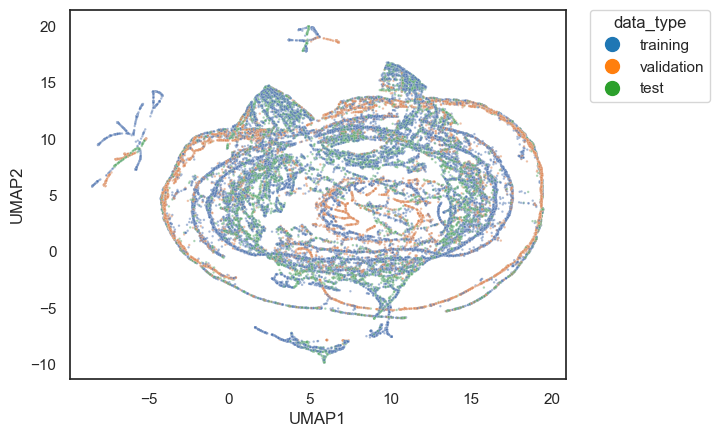

In [42]:
sns.scatterplot(data=viz_df,x='UMAP1',y='UMAP2',hue='data_type',alpha=0.5,s=3)


# Get unique video_ids to create custom legend entries
unique_video_ids = viz_df['data_type'].unique()
# Create a list of handles for the legend
legend_handles = [mlines.Line2D([], [], color=sns.color_palette('tab10')[i], marker='o', linestyle='None', markersize=10, label=video_id) for i, video_id in enumerate(unique_video_ids)]

# Place the legend outside the plot with custom handles
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='data_type', ncol=1)

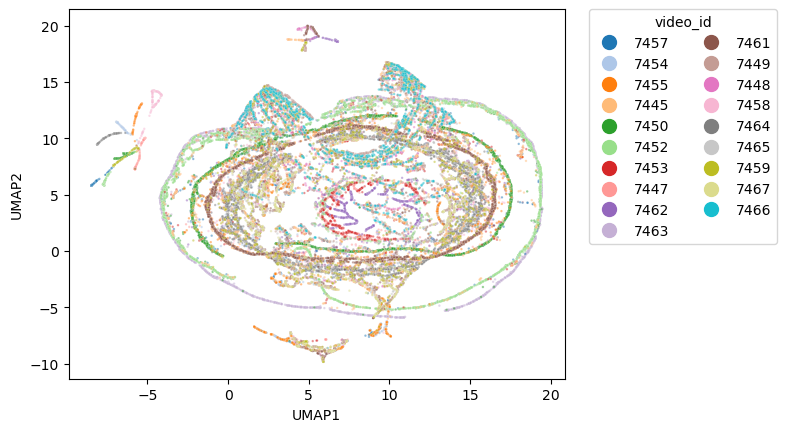

In [34]:

sns.scatterplot(data=viz_df, x='UMAP1', y='UMAP2', hue='video_id', alpha=0.5, s=3, palette='tab20')

# Get unique video_ids to create custom legend entries
unique_video_ids = viz_df['video_id'].unique()
# Create a list of handles for the legend
legend_handles = [mlines.Line2D([], [], color=sns.color_palette('tab20')[i], marker='o', linestyle='None', markersize=10, label=video_id) for i, video_id in enumerate(unique_video_ids)]

# Place the legend outside the plot with custom handles
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='video_id', ncol=2)

Text(0.5, 1.0, 'Color by frame number')

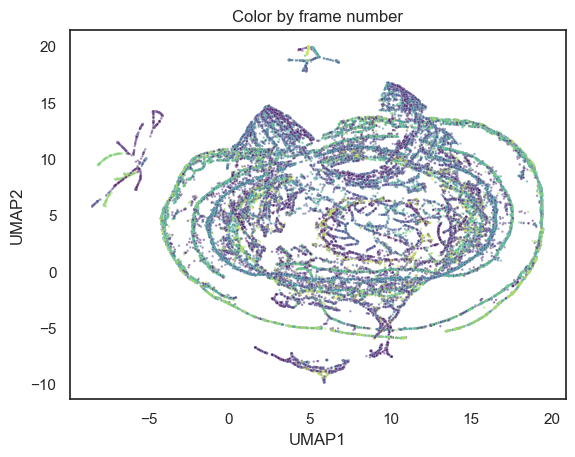

In [50]:
sns.scatterplot(data=viz_df, x='UMAP1', y='UMAP2', hue='frame', alpha=0.5, s=3, palette='viridis')
# remove the legend
plt.legend().remove()
plt.title('Color by frame number') 



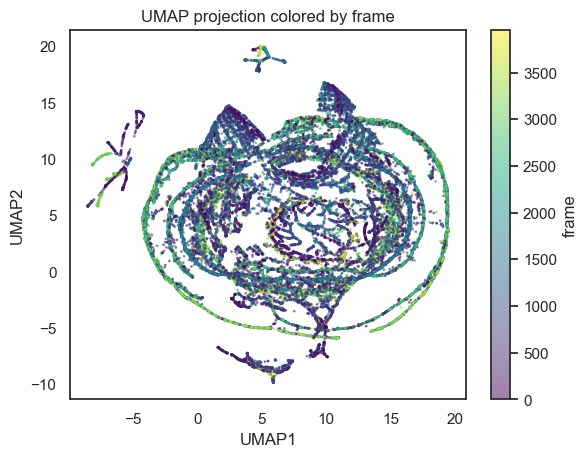

In [40]:

# Set the seaborn style
# sns.set(style="white")

# Create the plot
fig, ax = plt.subplots()
scatter = ax.scatter(viz_df['UMAP1'], viz_df['UMAP2'], c=viz_df['frame'], alpha=0.5, s=1, cmap='viridis')

# Create colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('frame')

# Set labels and title
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('UMAP projection colored by frame')

plt.show()

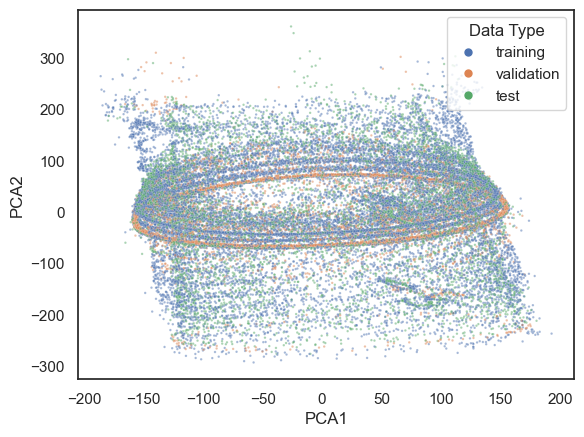

In [43]:

# Scatter plot of PCA components
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='data_type', alpha=0.5, s=3)

# Legend
unique_data_types = viz_df['data_type'].unique()
legend_handles = [plt.Line2D([], [], color=sns.color_palette()[i], marker='o', linestyle='None', markersize=5, label=data_type) for i, data_type in enumerate(unique_data_types)]
plt.legend(handles=legend_handles, title='Data Type')


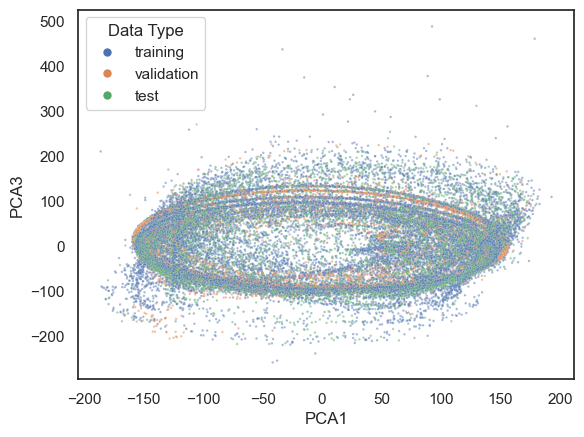

In [45]:

# Scatter plot of PCA components
sns.scatterplot(data=viz_df, x='PCA1', y='PCA3', hue='data_type', alpha=0.5, s=3)

# Legend
unique_data_types = viz_df['data_type'].unique()
legend_handles = [plt.Line2D([], [], color=sns.color_palette()[i], marker='o', linestyle='None', markersize=5, label=data_type) for i, data_type in enumerate(unique_data_types)]
plt.legend(handles=legend_handles, title='Data Type')

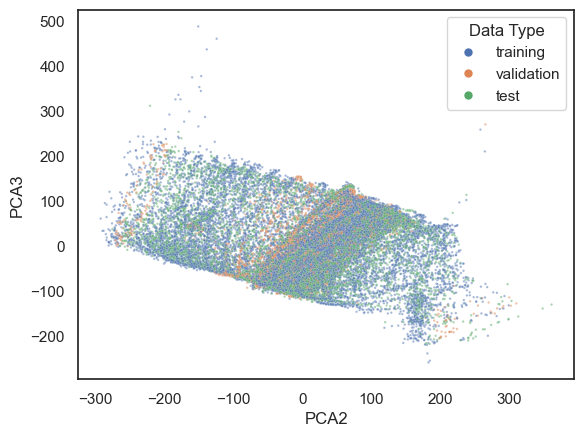

In [46]:

# Scatter plot of PCA components
sns.scatterplot(data=viz_df, x='PCA2', y='PCA3', hue='data_type', alpha=0.5, s=3)

# Legend
unique_data_types = viz_df['data_type'].unique()
legend_handles = [plt.Line2D([], [], color=sns.color_palette()[i], marker='o', linestyle='None', markersize=5, label=data_type) for i, data_type in enumerate(unique_data_types)]
plt.legend(handles=legend_handles, title='Data Type')

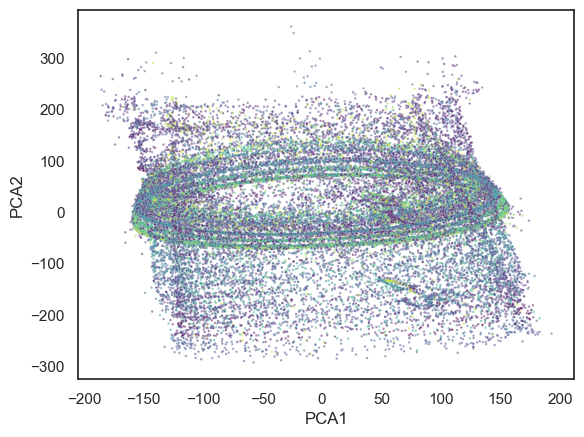

In [49]:
# Scatter plot of PCA components
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='frame', alpha=0.5, s=3, palette='viridis')
# remove the legend
plt.legend().remove()
plt.title('Color by Frame Number')



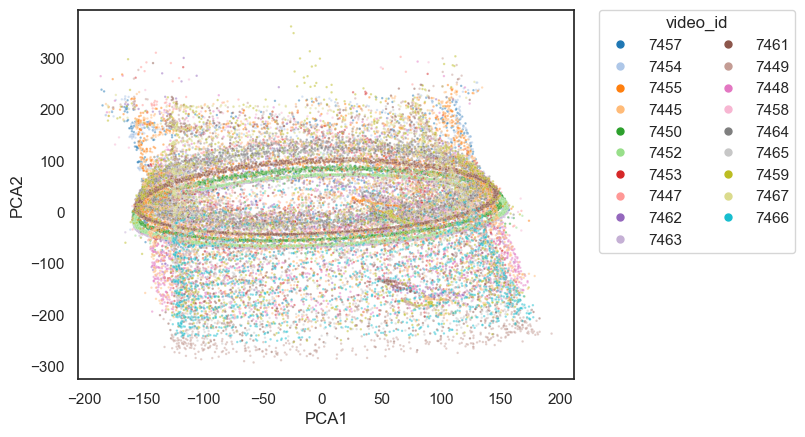

In [55]:
# Scatter plot of PCA components
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='video_id', alpha=0.5, s=3, palette='tab20')
# Legend
unique_data_types = viz_df['video_id'].unique()
legend_handles = [plt.Line2D([], [], color=sns.color_palette('tab20')[i], marker='o', linestyle='None', markersize=5, label=video_id) for i, video_id in enumerate(unique_data_types)]

# place the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Video ID', ncols=2)
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='video_id', ncol=2)


## Optimize the Model with Optuna

In [62]:
! pip install wandb

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 3.9 MB/s eta 0:00:0000:0100:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.2 MB/s eta 0:00:0000:01


In [3]:
timesteps_to_use = 10
use_wandb = True

In [5]:
ellipse_cols = [col for col in df.columns if 'ellipse' in col]
input_size = len(ellipse_cols)

In [6]:
df_train = df[df['data_type'] == 'training'].copy()
df_val = df[df['data_type'] == 'validation'].copy()
df_test = df[df['data_type'] == 'test'].copy()

In [7]:
frames_train = df_train['frame'].values
data_train = df_train[ellipse_cols].values

frames_val = df_val['frame'].values
data_val = df_val[ellipse_cols].values

frames_test = df_test['frame'].values
data_test = df_test[ellipse_cols].values

In [8]:
X_train, y_train, t_train = create_sequences(data_train, 
                                             timesteps=timesteps_to_use, 
                                             frames=frames_train,
                                             remove_nans=True)

X_val, y_val, t_val = create_sequences(data_val,
                                        timesteps=timesteps_to_use,
                                        frames=frames_val,
                                        remove_nans=True)

X_test, y_test, t_test = create_sequences(data_test,
                                            timesteps=timesteps_to_use,
                                            frames=frames_test,
                                            remove_nans=True)

In [9]:
if use_wandb:
    import wandb

In [16]:
def objective(trial):

    # Define the hyperparameters to search
    num_layers = trial.suggest_int('num_layers', 1, 5, step=1)
    hidden_size = trial.suggest_int('hidden_size', 16, 128, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 10, 100, step=10)

    if use_wandb:
        wandb.init(project='hulahoop_lstm')
        wandb.config.num_layers = num_layers
        wandb.config.hidden_size = hidden_size
        wandb.config.dropout_rate = dropout_rate
        wandb.config.learning_rate = learning_rate
        wandb.config.weight_decay = weight_decay
        wandb.config.num_epochs = num_epochs
        wandb.config.timesteps = timesteps_to_use
        wandb.config.data_scaler = 'MinMaxScaler'

    # Define the model
    model = HulaHoopLSTM(
                        input_size = input_size,
                        output_size = input_size,
                        num_layers=num_layers, 
                        hidden_size=hidden_size, 
                        dropout=dropout_rate,
                        learning_rate=learning_rate,
                        weight_decay=weight_decay
                        data_scaler=MinMaxScaler(),
                        )

    # if use_wandb:
    #     wandb.watch(model.net, log_freq=100)

    # Train the model
    model.fit(X_train, y_train, 
              num_epoch=num_epochs, 
              batch_size=32)

    # Evaluate the model
    loss_dict = model.evaluate(X_val, y_val)
    loss = loss_dict['total']
    if use_wandb:
        wandb.log(loss_dict)

    return loss

### Note to self
forgot to give the hulahuoop model a minmax scaler, I should do that before I run the optimization

In [17]:
study = optuna.create_study(direction='minimize',
                            study_name='hulahoop_lstm',
                            storage='sqlite:///hulahoop_lstm.db',
                            load_if_exists=True)

study.optimize(objective, n_trials=98)

[I 2024-06-17 23:35:22,492] Using an existing study with name 'hulahoop_lstm' instead of creating a new one.


total,▁
total,26160.73242


Epoch 0:	 loss=73612.3533
Epoch 10:	 loss=72653.8302
Epoch 20:	 loss=71983.8000
Epoch 30:	 loss=71368.4388
Epoch 40:	 loss=70768.4716
Epoch 50:	 loss=70171.3767
Epoch 60:	 loss=69580.3241


[I 2024-06-17 23:39:43,299] Trial 4 finished with value: 70745.0625 and parameters: {'num_layers': 4, 'hidden_size': 16, 'dropout_rate': 0.1, 'learning_rate': 1.1247574840232685e-05, 'weight_decay': 1.0135901310239254e-05, 'num_epochs': 70}. Best is trial 2 with value: 2082.088134765625.


total,▁
total,70745.0625


Epoch 0:	 loss=61325.4434


[I 2024-06-17 23:42:42,665] Trial 5 finished with value: 2918.448486328125 and parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0007923681377117893, 'weight_decay': 1.4021723752202114e-05, 'num_epochs': 10}. Best is trial 2 with value: 2082.088134765625.


total,▁
total,2918.44849


Epoch 0:	 loss=45753.6134
Epoch 10:	 loss=2433.8398
Epoch 20:	 loss=2433.5612
Epoch 30:	 loss=2433.5935
Epoch 40:	 loss=2433.7676
Epoch 50:	 loss=2433.8747
Epoch 60:	 loss=2433.7856


[I 2024-06-17 23:53:24,013] Trial 6 finished with value: 2080.080078125 and parameters: {'num_layers': 4, 'hidden_size': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.003548065577311223, 'weight_decay': 0.0004648234043739645, 'num_epochs': 70}. Best is trial 6 with value: 2080.080078125.


total,▁
total,2080.08008


Epoch 0:	 loss=73183.8918
Epoch 10:	 loss=68743.6054
Epoch 20:	 loss=65258.0165
Epoch 30:	 loss=61906.6741
Epoch 40:	 loss=58690.3496
Epoch 50:	 loss=55606.7101
Epoch 60:	 loss=52655.2866
Epoch 70:	 loss=49838.5430


[I 2024-06-18 00:12:47,854] Trial 7 finished with value: 48746.27734375 and parameters: {'num_layers': 4, 'hidden_size': 112, 'dropout_rate': 0.2, 'learning_rate': 1.029838081439447e-05, 'weight_decay': 0.0033161405651126524, 'num_epochs': 80}. Best is trial 6 with value: 2080.080078125.


total,▁
total,48746.27734


Epoch 0:	 loss=47579.5639
Epoch 10:	 loss=2433.5346


[I 2024-06-18 00:17:59,730] Trial 8 finished with value: 2071.201171875 and parameters: {'num_layers': 2, 'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0016080146875225502, 'weight_decay': 0.004744673122797626, 'num_epochs': 20}. Best is trial 8 with value: 2071.201171875.


total,▁
total,2071.20117


Epoch 0:	 loss=61077.4934
Epoch 10:	 loss=2672.4174
Epoch 20:	 loss=2433.0426
Epoch 30:	 loss=2433.1807
Epoch 40:	 loss=2433.1242


[I 2024-06-18 00:23:05,879] Trial 9 finished with value: 2084.83740234375 and parameters: {'num_layers': 5, 'hidden_size': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0024849800167741085, 'weight_decay': 0.002034921860178698, 'num_epochs': 50}. Best is trial 8 with value: 2071.201171875.


total,▁
total,2084.8374


Epoch 0:	 loss=48838.3892
Epoch 10:	 loss=2433.1362
Epoch 20:	 loss=2083.5598
Epoch 30:	 loss=1277.4649
Epoch 40:	 loss=1119.1581
Epoch 50:	 loss=1026.5914
Epoch 60:	 loss=807.4130


[I 2024-06-18 00:39:27,233] Trial 10 finished with value: 766.2138671875 and parameters: {'num_layers': 2, 'hidden_size': 128, 'dropout_rate': 0.5, 'learning_rate': 0.00148954270088646, 'weight_decay': 0.0022409907834321638, 'num_epochs': 70}. Best is trial 10 with value: 766.2138671875.


total,▁
total,766.21387


Epoch 0:	 loss=73601.5812
Epoch 10:	 loss=71495.3488
Epoch 20:	 loss=70049.3216
Epoch 30:	 loss=68633.8613
Epoch 40:	 loss=67240.2415
Epoch 50:	 loss=65865.8996


[I 2024-06-18 00:43:21,405] Trial 11 finished with value: 66253.9375 and parameters: {'num_layers': 3, 'hidden_size': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 1.3935582993436156e-05, 'weight_decay': 0.0009877551978530004, 'num_epochs': 60}. Best is trial 10 with value: 766.2138671875.


total,▁
total,66253.9375


/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:	 loss=73057.3280
Epoch 10:	 loss=63236.7973
Epoch 20:	 loss=54266.5125
Epoch 30:	 loss=46177.3038


[I 2024-06-18 00:46:08,505] Trial 12 finished with value: 40862.18359375 and parameters: {'num_layers': 1, 'hidden_size': 64, 'dropout_rate': 0.5, 'learning_rate': 0.00011889010847130545, 'weight_decay': 8.83625525184256e-05, 'num_epochs': 40}. Best is trial 10 with value: 766.2138671875.


total,▁
total,40862.18359


/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:	 loss=69032.7059
Epoch 10:	 loss=16367.0375


[I 2024-06-18 00:49:48,561] Trial 13 finished with value: 3624.35546875 and parameters: {'num_layers': 1, 'hidden_size': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0004403915901212631, 'weight_decay': 0.00891247113078499, 'num_epochs': 20}. Best is trial 10 with value: 766.2138671875.


total,▁
total,3624.35547


Epoch 0:	 loss=17668.8773
Epoch 10:	 loss=2436.0821
Epoch 20:	 loss=2436.8777


[I 2024-06-18 00:56:19,362] Trial 14 finished with value: 2087.6240234375 and parameters: {'num_layers': 2, 'hidden_size': 128, 'dropout_rate': 0.4, 'learning_rate': 0.008206355282699331, 'weight_decay': 0.0012134518257263282, 'num_epochs': 30}. Best is trial 10 with value: 766.2138671875.


total,▁
total,2087.62402


Epoch 0:	 loss=61557.8295
Epoch 10:	 loss=2920.9396
Epoch 20:	 loss=2039.6220
Epoch 30:	 loss=1518.2855
Epoch 40:	 loss=1155.7719
Epoch 50:	 loss=816.6990
Epoch 60:	 loss=633.8352
Epoch 70:	 loss=469.2640
Epoch 80:	 loss=415.0377
Epoch 90:	 loss=330.0589


[I 2024-06-18 01:17:02,315] Trial 15 finished with value: 1637.4176025390625 and parameters: {'num_layers': 3, 'hidden_size': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0007771871797211625, 'weight_decay': 0.008405523537780023, 'num_epochs': 100}. Best is trial 10 with value: 766.2138671875.


total,▁
total,1637.4176


Epoch 0:	 loss=70442.7015
Epoch 10:	 loss=38022.9874
Epoch 20:	 loss=19584.0380
Epoch 30:	 loss=9389.8090
Epoch 40:	 loss=4477.6379
Epoch 50:	 loss=2778.1259
Epoch 60:	 loss=1789.0864
Epoch 70:	 loss=1325.3444
Epoch 80:	 loss=909.9553
Epoch 90:	 loss=566.0307


[I 2024-06-18 01:34:05,251] Trial 16 finished with value: 348.2901611328125 and parameters: {'num_layers': 3, 'hidden_size': 96, 'dropout_rate': 0.4, 'learning_rate': 0.00013971570853352707, 'weight_decay': 0.008231519032829102, 'num_epochs': 100}. Best is trial 16 with value: 348.2901611328125.


total,▁
total,348.29016


Epoch 0:	 loss=71212.0685
Epoch 10:	 loss=46176.5213
Epoch 20:	 loss=29320.7716
Epoch 30:	 loss=18042.7677
Epoch 40:	 loss=10607.2003
Epoch 50:	 loss=6064.4052
Epoch 60:	 loss=3757.5851
Epoch 70:	 loss=2742.3830
Epoch 80:	 loss=2441.0852


[I 2024-06-18 01:44:42,638] Trial 17 finished with value: 2083.39453125 and parameters: {'num_layers': 3, 'hidden_size': 80, 'dropout_rate': 0.5, 'learning_rate': 0.00011686800956074055, 'weight_decay': 0.0004059294777901471, 'num_epochs': 90}. Best is trial 16 with value: 348.2901611328125.


total,▁
total,2083.39453


/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0:	 loss=72970.3988
Epoch 10:	 loss=59406.0352
Epoch 20:	 loss=47915.8267
Epoch 30:	 loss=38252.0101
Epoch 40:	 loss=30384.5118
Epoch 50:	 loss=23944.6036
Epoch 60:	 loss=18775.0972
Epoch 70:	 loss=14518.3217
Epoch 80:	 loss=11069.0275


[I 2024-06-18 01:51:43,886] Trial 18 finished with value: 9119.462890625 and parameters: {'num_layers': 1, 'hidden_size': 80, 'dropout_rate': 0.4, 'learning_rate': 0.00011065016125066127, 'weight_decay': 0.001352975138028836, 'num_epochs': 90}. Best is trial 16 with value: 348.2901611328125.


total,▁
total,9119.46289


Epoch 0:	 loss=72276.7304
Epoch 10:	 loss=59590.1546
Epoch 20:	 loss=49347.0859
Epoch 30:	 loss=40636.0873
Epoch 40:	 loss=33290.5447
Epoch 50:	 loss=27072.7987


[I 2024-06-18 02:01:06,242] Trial 19 finished with value: 23217.490234375 and parameters: {'num_layers': 2, 'hidden_size': 112, 'dropout_rate': 0.5, 'learning_rate': 3.599841272365648e-05, 'weight_decay': 0.00014255408380105814, 'num_epochs': 60}. Best is trial 16 with value: 348.2901611328125.


total,▁
total,23217.49023


Epoch 0:	 loss=67565.8659
Epoch 10:	 loss=16148.2414
Epoch 20:	 loss=3496.7026
Epoch 30:	 loss=1660.1740
Epoch 40:	 loss=785.5902
Epoch 50:	 loss=281.5482
Epoch 60:	 loss=171.0007
Epoch 70:	 loss=141.0209


[I 2024-06-18 02:21:49,828] Trial 20 finished with value: 154.80239868164062 and parameters: {'num_layers': 3, 'hidden_size': 112, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002757139648399649, 'weight_decay': 0.0028458331738577597, 'num_epochs': 80}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,154.8024


Epoch 0:	 loss=71195.5393
Epoch 10:	 loss=43433.3764
Epoch 20:	 loss=25683.1932
Epoch 30:	 loss=14539.5424
Epoch 40:	 loss=7765.8483
Epoch 50:	 loss=4263.5520
Epoch 60:	 loss=2857.0259
Epoch 70:	 loss=2444.1200
Epoch 80:	 loss=2432.8284


[I 2024-06-18 02:31:56,393] Trial 21 finished with value: 2087.6982421875 and parameters: {'num_layers': 4, 'hidden_size': 48, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00022112663374108317, 'weight_decay': 0.0006728404366584212, 'num_epochs': 90}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,2087.69824


Epoch 0:	 loss=72700.2818
Epoch 10:	 loss=63676.3375
Epoch 20:	 loss=55915.1460
Epoch 30:	 loss=48953.6396
Epoch 40:	 loss=42750.7438
Epoch 50:	 loss=37258.5198
Epoch 60:	 loss=32358.2267
Epoch 70:	 loss=28001.9985
Epoch 80:	 loss=24173.6222
Epoch 90:	 loss=20841.7617


[I 2024-06-18 02:44:10,953] Trial 22 finished with value: 19010.306640625 and parameters: {'num_layers': 3, 'hidden_size': 80, 'dropout_rate': 0.30000000000000004, 'learning_rate': 3.506273716716533e-05, 'weight_decay': 0.0002106550860280926, 'num_epochs': 100}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,19010.30664


Epoch 0:	 loss=67488.2901
Epoch 10:	 loss=15213.1804
Epoch 20:	 loss=3250.5618
Epoch 30:	 loss=2041.8312
Epoch 40:	 loss=959.2810
Epoch 50:	 loss=347.2789
Epoch 60:	 loss=188.8546
Epoch 70:	 loss=149.9346


[I 2024-06-18 03:06:33,759] Trial 23 finished with value: 177.23089599609375 and parameters: {'num_layers': 3, 'hidden_size': 112, 'dropout_rate': 0.4, 'learning_rate': 0.00028487734861659865, 'weight_decay': 0.0025150755724730636, 'num_epochs': 80}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,177.2309


Epoch 0:	 loss=68754.6924
Epoch 10:	 loss=22893.4532
Epoch 20:	 loss=6460.0277
Epoch 30:	 loss=2645.0988
Epoch 40:	 loss=1554.9242
Epoch 50:	 loss=843.3068
Epoch 60:	 loss=371.6245
Epoch 70:	 loss=197.4766


[I 2024-06-18 03:24:35,938] Trial 24 finished with value: 184.3277130126953 and parameters: {'num_layers': 3, 'hidden_size': 112, 'dropout_rate': 0.4, 'learning_rate': 0.0002118056613372923, 'weight_decay': 0.00446142524832117, 'num_epochs': 80}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,184.32771


Epoch 0:	 loss=66566.7948
Epoch 10:	 loss=11211.5652
Epoch 20:	 loss=2582.2492
Epoch 30:	 loss=1940.7235
Epoch 40:	 loss=803.9143
Epoch 50:	 loss=289.0127
Epoch 60:	 loss=191.5341
Epoch 70:	 loss=158.0774


[I 2024-06-18 03:48:43,182] Trial 25 finished with value: 206.0845489501953 and parameters: {'num_layers': 4, 'hidden_size': 112, 'dropout_rate': 0.4, 'learning_rate': 0.000338167936600045, 'weight_decay': 0.0028664660656153827, 'num_epochs': 80}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,206.08455


Epoch 0:	 loss=71892.1459
Epoch 10:	 loss=55924.1357
Epoch 20:	 loss=43253.7480
Epoch 30:	 loss=33140.7640
Epoch 40:	 loss=25082.0676


[I 2024-06-18 04:00:42,835] Trial 26 finished with value: 20102.19140625 and parameters: {'num_layers': 3, 'hidden_size': 112, 'dropout_rate': 0.30000000000000004, 'learning_rate': 4.8571383752222456e-05, 'weight_decay': 3.602010832789494e-05, 'num_epochs': 50}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,20102.19141


Epoch 0:	 loss=63692.8904
Epoch 10:	 loss=4412.0329
Epoch 20:	 loss=2433.2388
Epoch 30:	 loss=1007.6183
Epoch 40:	 loss=306.5522
Epoch 50:	 loss=227.9946
Epoch 60:	 loss=200.2272
Epoch 70:	 loss=184.1588


[I 2024-06-18 04:16:58,516] Trial 27 finished with value: 196.90625 and parameters: {'num_layers': 3, 'hidden_size': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0006077725716436946, 'weight_decay': 0.0049015277793452595, 'num_epochs': 80}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,196.90625


Epoch 0:	 loss=68035.1258
Epoch 10:	 loss=18296.5539
Epoch 20:	 loss=4186.1020
Epoch 30:	 loss=1935.9327
Epoch 40:	 loss=984.0335
Epoch 50:	 loss=381.7107
Epoch 60:	 loss=178.7994


[I 2024-06-18 04:35:50,491] Trial 28 finished with value: 159.2703399658203 and parameters: {'num_layers': 3, 'hidden_size': 112, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002516101896339101, 'weight_decay': 0.0016170586203322638, 'num_epochs': 70}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,159.27034


Epoch 0:	 loss=70915.6620
Epoch 10:	 loss=44312.6646
Epoch 20:	 loss=26963.3629
Epoch 30:	 loss=15794.7266
Epoch 40:	 loss=8765.7507
Epoch 50:	 loss=4861.4400


[I 2024-06-18 04:53:31,348] Trial 29 finished with value: 3267.249267578125 and parameters: {'num_layers': 4, 'hidden_size': 128, 'dropout_rate': 0.2, 'learning_rate': 7.969079803657171e-05, 'weight_decay': 0.0007996646945256025, 'num_epochs': 60}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,3267.24927


Epoch 0:	 loss=69360.9689
Epoch 10:	 loss=27501.7542
Epoch 20:	 loss=9575.7523
Epoch 30:	 loss=3464.1391
Epoch 40:	 loss=2225.7135
Epoch 50:	 loss=1340.2746
Epoch 60:	 loss=734.1113


[I 2024-06-18 05:06:24,301] Trial 30 finished with value: 353.9340515136719 and parameters: {'num_layers': 4, 'hidden_size': 80, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002487707990460504, 'weight_decay': 0.0015238622259215824, 'num_epochs': 70}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,353.93405


Epoch 0:	 loss=71812.8481
Epoch 10:	 loss=53357.2450
Epoch 20:	 loss=39445.2398
Epoch 30:	 loss=28754.4760
Epoch 40:	 loss=20658.9535
Epoch 50:	 loss=14572.5907
Epoch 60:	 loss=10014.3964
Epoch 70:	 loss=6801.7223
Epoch 80:	 loss=4707.5716


[I 2024-06-18 05:15:06,867] Trial 31 finished with value: 3717.53759765625 and parameters: {'num_layers': 2, 'hidden_size': 96, 'dropout_rate': 0.1, 'learning_rate': 6.624097410126797e-05, 'weight_decay': 0.0005368118424232744, 'num_epochs': 90}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,3717.5376


Epoch 0:	 loss=66021.1773
Epoch 10:	 loss=9098.4798
Epoch 20:	 loss=2457.4026
Epoch 30:	 loss=2174.2966
Epoch 40:	 loss=851.8141
Epoch 50:	 loss=261.9557
Epoch 60:	 loss=168.6768


[I 2024-06-18 05:35:54,064] Trial 32 finished with value: 171.00091552734375 and parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.2, 'learning_rate': 0.00043706726407607906, 'weight_decay': 0.0018061454609493374, 'num_epochs': 70}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,171.00092


Epoch 0:	 loss=65856.5616
Epoch 10:	 loss=8785.0086
Epoch 20:	 loss=2450.2651
Epoch 30:	 loss=1564.0731
Epoch 40:	 loss=453.6349
Epoch 50:	 loss=192.1986
Epoch 60:	 loss=146.0027


[I 2024-06-18 05:56:32,890] Trial 33 finished with value: 159.1577911376953 and parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0004434074285493665, 'weight_decay': 0.0019319507446285272, 'num_epochs': 70}. Best is trial 20 with value: 154.80239868164062.


total,▁
total,159.15779


Epoch 0:	 loss=65101.2128
Epoch 10:	 loss=6688.0052
Epoch 20:	 loss=2242.8065
Epoch 30:	 loss=878.6726
Epoch 40:	 loss=196.9006
Epoch 50:	 loss=120.6380
Epoch 60:	 loss=93.7177


[I 2024-06-18 06:16:58,048] Trial 34 finished with value: 129.4212188720703 and parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.0, 'learning_rate': 0.0005024854649428563, 'weight_decay': 0.0017485890095628215, 'num_epochs': 70}. Best is trial 34 with value: 129.4212188720703.


total,▁
total,129.42122


Epoch 0:	 loss=57090.7265
Epoch 10:	 loss=2434.8595
Epoch 20:	 loss=2433.2939
Epoch 30:	 loss=2433.1477
Epoch 40:	 loss=2433.4966
Epoch 50:	 loss=690.8126


[I 2024-06-18 06:34:42,538] Trial 35 finished with value: 372.1675720214844 and parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.0, 'learning_rate': 0.0011616515353143155, 'weight_decay': 0.00024978908475315994, 'num_epochs': 60}. Best is trial 34 with value: 129.4212188720703.


total,▁
total,372.16757


Epoch 0:	 loss=65811.4587
Epoch 10:	 loss=8744.7250
Epoch 20:	 loss=2451.7911
Epoch 30:	 loss=1904.1390
Epoch 40:	 loss=633.7666


[I 2024-06-18 06:46:37,149] Trial 36 finished with value: 235.439208984375 and parameters: {'num_layers': 5, 'hidden_size': 80, 'dropout_rate': 0.0, 'learning_rate': 0.0005350904900760208, 'weight_decay': 0.003902756776916312, 'num_epochs': 50}. Best is trial 34 with value: 129.4212188720703.


total,▁
total,235.43921


Epoch 0:	 loss=71059.0813
Epoch 10:	 loss=43494.3219
Epoch 20:	 loss=25833.0702
Epoch 30:	 loss=14712.9299
Epoch 40:	 loss=7928.2170
Epoch 50:	 loss=4367.6688
Epoch 60:	 loss=2907.8042


[I 2024-06-18 06:58:35,019] Trial 37 finished with value: 2176.406982421875 and parameters: {'num_layers': 5, 'hidden_size': 64, 'dropout_rate': 0.1, 'learning_rate': 0.00016547602688182027, 'weight_decay': 0.0009990047748112648, 'num_epochs': 70}. Best is trial 34 with value: 129.4212188720703.


total,▁
total,2176.40698


Epoch 0:	 loss=58548.6336
Epoch 10:	 loss=2456.2023
Epoch 20:	 loss=2433.1241
Epoch 30:	 loss=2432.9725
Epoch 40:	 loss=2433.7135
Epoch 50:	 loss=719.6345
Epoch 60:	 loss=296.7907


[I 2024-06-18 07:22:08,997] Trial 38 finished with value: 480.3799743652344 and parameters: {'num_layers': 4, 'hidden_size': 112, 'dropout_rate': 0.1, 'learning_rate': 0.000885851469128972, 'weight_decay': 0.005588823940551546, 'num_epochs': 70}. Best is trial 34 with value: 129.4212188720703.


total,▁
total,480.37997


Epoch 0:	 loss=66800.6539
Epoch 10:	 loss=11992.9363
Epoch 20:	 loss=2664.2274


[W 2024-06-18 07:30:29,135] Trial 39 failed with parameters: {'num_layers': 5, 'hidden_size': 96, 'dropout_rate': 0.0, 'learning_rate': 0.00038029956936802377, 'weight_decay': 0.0017311716984469213, 'num_epochs': 80} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/wl/x58pc4s51gl9xvvgmg5q2wxm0000gn/T/ipykernel_10321/772598714.py", line 35, in objective
    model.fit(X_train, y_train,
  File "/Users/jonaheaton/Documents/GitHub/hula_hoop/model.py", line 226, in fit
    loss = self._train_one_epoch(dataloader)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jonaheaton/Documents/GitHub/hula_hoop/model.py", line 182, in _train_one_epoch
    y_pred = self.net(x)
             ^^^^^^^^^^^
  File "/Users/jonaheaton/Doc

KeyboardInterrupt: 